In [42]:
import dlib
import cv2
import os
import glob
from preprocessing.scarpping_component import extract_component_by_images

# Initialize dlib face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

# Hapus Semua File Hasil Test
files = glob.glob('hasil_test/*')
for f in files:
    os.remove(f)

# Define component setup
components_setup = {
    'mulut': {
        'object_name': 'mouth',
        'object_rectangle': {"x_right": 54, "x_left": 48, "y_highest": 52, "y_lowest": 57},
        'pixel_shifting': {"pixel_x": 25, "pixel_y": 5},
        'object_dimension': {'width': 140, 'height': 40}
    },
    'mata_kiri': {
        'object_name': 'eye_left',
        'object_rectangle': {"x_right": 39, "x_left": 36, "y_highest": 38, "y_lowest": 41},
        'pixel_shifting': {"pixel_x": 25, "pixel_y": 25},
        'object_dimension': {'width': 90, 'height': 55}
    },
    'mata_kanan': {
        'object_name': 'eye_right',
        'object_rectangle': {"x_right": 45, "x_left": 42, "y_highest": 43, "y_lowest": 47},
        'pixel_shifting': {"pixel_x": 25, "pixel_y": 25},
        'object_dimension': {'width': 90, 'height': 55}
    },
    'alis_kiri': {
        'object_name': 'eyebrow_left',
        'object_rectangle': {"x_right": 21, "x_left": 17, "y_highest": 18, "y_lowest": 21},
        'pixel_shifting': {"pixel_x": 15, "pixel_y": 15},
        'object_dimension': {'width': 110, 'height': 40}
    },
    'alis_kanan': {
        'object_name': 'eyebrow_right',
        'object_rectangle': {"x_right": 26, "x_left": 22, "y_highest": 25, "y_lowest": 22},
        'pixel_shifting': {"pixel_x": 15, "pixel_y": 15},
        'object_dimension': {'width': 110, 'height': 40}
    },
    'hidung_kanan': {
        'object_name': 'nose_right',
        'object_rectangle': {"x_right": 31, "x_left": 40, "y_highest": 40, "y_lowest": 48},
        'pixel_shifting': {"pixel_x": 15, "pixel_y": -25},
        'object_dimension': {'width': 70, 'height': 40}
    },
    'hidung_kiri': {
        'object_name': 'nose_left',
        'object_rectangle': {"x_right": 47, "x_left": 35, "y_highest": 47, "y_lowest": 54},
        'pixel_shifting': {"pixel_x": 15, "pixel_y": -25},
        'object_dimension': {'width': 70, 'height': 40}
    }
}

def create_blocks(image, block_size):
    h, w = image.shape[:2]
    block_number = 1

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if x + block_size <= w and y + block_size <= h:
                cv2.rectangle(image, (x, y), (x + block_size, y + block_size), (0, 255, 0), 1)
                cv2.putText(image, str(block_number), (x + 2, y + 12), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
                block_number += 1
    return image

# Load image
# image_path = 'images/cina.jpg'

image_path = 'output_image_5x5/frame2.jpg'


image = cv2.imread(image_path)
if image is None:
    print(f"Error loading image from path: {image_path}")
else:
    # Resize image
    image = cv2.resize(image, (600, 500))
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    rects = detector(gray)

    if len(rects) == 0:
        print("No faces detected.")
    else:
        for rect in rects:
            # Draw rectangle around the face
            cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
            
            # Predict facial landmarks
            shape = predictor(gray, rect)

            for component_name, component_info in components_setup.items():
                print(f"\nProcessing {component_info['object_name']}")

                # Extract component by image
                data_blocks_image_current = extract_component_by_images(
                    image=image,
                    shape=shape,
                    frameName=component_name,
                    objectName=component_info['object_name'],
                    objectRectangle=component_info['object_rectangle'],
                    pixelShifting=component_info['pixel_shifting'],
                    objectDimension=component_info['object_dimension']
                )

                # Without blocks
                output_path = f'hasil_test/{component_info["object_name"]}.jpg'
                cv2.imwrite(output_path, data_blocks_image_current)
                print(f"Image without blocks saved at: {output_path}")

                # Resize component image
                scale_factor = 5  # Increase size by 5 times
                resized_component_image = cv2.resize(data_blocks_image_current, 
                                                     (data_blocks_image_current.shape[1] * scale_factor, 
                                                      data_blocks_image_current.shape[0] * scale_factor))

                # Create 5x5 blocks for the resized component image
                block_size = 5 * scale_factor  # Adjust block size according to the scale factor
                component_image_with_blocks = create_blocks(resized_component_image, block_size)

                # Save the result
                output_path = f'hasil_test/{component_info["object_name"]}_with_blocks.jpg'
                cv2.imwrite(output_path, component_image_with_blocks)
                print(f"Image with blocks saved at: {output_path}")

                # Draw the rectangle of the component on the original image
                cv2.rectangle(image, (shape.part(component_info['object_rectangle']['x_left']).x, shape.part(component_info['object_rectangle']['y_highest']).y),
                              (shape.part(component_info['object_rectangle']['x_right']).x, shape.part(component_info['object_rectangle']['y_lowest']).y),
                              (0, 0, 255), 2)
        
        # Save image with face detection and components rectangles for debugging
        debug_image_path = 'hasil_test/detected_faces_with_components.jpg'

        # Masking tiap landmark
        for i in range(0, 68):
            x = shape.part(i).x
            y = shape.part(i).y
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
            cv2.putText(image, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

        cv2.imwrite(debug_image_path, image)
        print(f"Image with face detection and components saved at: {debug_image_path}")
        print("Processing completed.")



Processing mouth
Image without blocks saved at: hasil_test/mouth.jpg
Image with blocks saved at: hasil_test/mouth_with_blocks.jpg

Processing eye_left
Image without blocks saved at: hasil_test/eye_left.jpg
Image with blocks saved at: hasil_test/eye_left_with_blocks.jpg

Processing eye_right
Image without blocks saved at: hasil_test/eye_right.jpg
Image with blocks saved at: hasil_test/eye_right_with_blocks.jpg

Processing eyebrow_left
Image without blocks saved at: hasil_test/eyebrow_left.jpg
Image with blocks saved at: hasil_test/eyebrow_left_with_blocks.jpg

Processing eyebrow_right
Image without blocks saved at: hasil_test/eyebrow_right.jpg
Image with blocks saved at: hasil_test/eyebrow_right_with_blocks.jpg

Processing nose_right
Image without blocks saved at: hasil_test/nose_right.jpg
Image with blocks saved at: hasil_test/nose_right_with_blocks.jpg

Processing nose_left
Image without blocks saved at: hasil_test/nose_left.jpg
Image with blocks saved at: hasil_test/nose_left_with_b

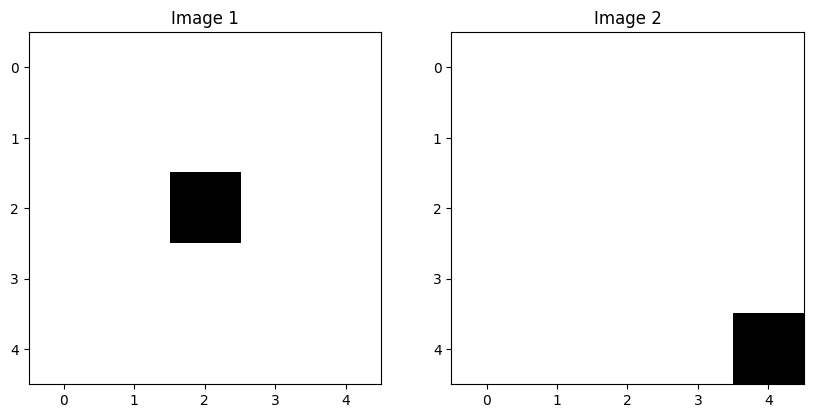

Hasil POC : [array([[[8.77227179e-17],
        [5.99055766e-17],
        [2.13162821e-16],
        [2.10400943e-16],
        [7.93358986e-17]],

       [[9.79019186e-17],
        [1.05356150e-16],
        [1.82076576e-16],
        [2.05953351e-16],
        [5.94772070e-17]],

       [[1.79243131e-16],
        [1.92168590e-16],
        [4.44089210e-18],
        [6.52319416e-17],
        [6.68551567e-17]],

       [[2.58411715e-16],
        [2.35574245e-16],
        [6.66133815e-17],
        [1.77100201e-16],
        [3.83856083e-17]],

       [[1.11022302e-16],
        [8.32667268e-17],
        [1.52655666e-16],
        [8.32667268e-17],
        [1.00000000e+00]]]), array([[5., 5.]]), array([[0., 0., 5., 5.]])]
Hasil Vektor : [[ 2.  2.  2.  2.  2. -2.]]
Hasil Quadran : [['0' 2 -2 315.0 2.828 'Q4']]
Nilai Fitur Dataset {'X1': 2, 'Y1': -2, 'Tetha1': 315.0, 'Magnitude1': 2.828}


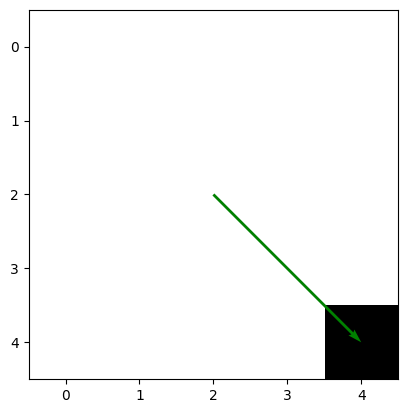

In [19]:
# Extraction Feature POC, Vektor, Quadran Test
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from feature_extraction.poc import POC
from feature_extraction.vektor import Vektor
from feature_extraction.quadran import Quadran


# Create two 5x5 pixel images with all white pixels
image1 = np.ones((5, 5), dtype=np.uint8) * 255
image2 = np.ones((5, 5), dtype=np.uint8) * 255

# Set one black pixel in image1
image1[2, 2] = 0

# Randomly select a position for the black pixel in image2
new_position = (np.random.randint(5), np.random.randint(5))

# Set the black pixel in the new position
image2[new_position] = 0

# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray')
plt.title('Image 2')

plt.show()


# Inisiasi class POC
initPOC = POC(image1, image2, 5)
# Pemanggilan fungsi pocCalc() untuk menghitung nilai POC disetiap gambar
valPOC = initPOC.getPOC() 
print('Hasil POC :', valPOC)

# Pemanggilan class dan method untuk menampilkan quiver / gambar panah
initQuiv = Vektor(valPOC, 5)
quivData = initQuiv.getVektor() 
print('Hasil Vektor :', quivData)

# Quadran
initQuadran = Quadran(quivData) 
quadran = initQuadran.getQuadran()

print('Hasil Quadran :' , quadran)

frame_data = {}

for i, quad in enumerate(quadran):
        # --- Setup bagian Nilai Fitur Dataset ---
        # Set data kedalam frame_data sesuai column nya
        frame_data[f'X{i+1}'] = quad[1]
        frame_data[f'Y{i+1}'] = quad[2]
        frame_data[f'Tetha{i+1}'] = quad[3]
        frame_data[f'Magnitude{i+1}'] = quad[4]

print("Nilai Fitur Dataset", frame_data)


# Menampilkan gambar dengan quiver
plt.imshow(np.uint8(image2), cmap='gray')
plt.quiver(quivData[:, 0], quivData[:, 1], quivData[:, 2], quivData[:, 3], scale=1, scale_units='xy', angles='xy', color="g")
plt.show()